In [1]:
#import modules
import pandas as pd
from collections.abc import MutableMapping
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import argparse
import numpy as np
import matplotlib.colors as mcolors

In [4]:
# Define a function to map repeat classes to consolidated categories
def map_repeat_class(integer):
    if isinstance(integer, int):
        return f'Satt_{integer}'
    else:
        raise ValueError("Input must be an integer")

## Example usage
#print(map_repeat_class(123))  # Output: Satt_123

In [5]:
# Set up argument parser
parser = argparse.ArgumentParser(description='Generate a chromosome ideogram with repeat sequences.')
parser.add_argument('-i', '--input', type=str, required=True, help='Path to the input file')
parser.add_argument(
    '-r', '--repeat_classes', type=int, nargs='+', required=True,
    help='Space-separated list of integers to create classes (e.g., 1 2 3)'
    )
parser.add_argument('-w', '--window_size', type=int, help='Window size for density calculation', default=None)
args = parser.parse_args()

# Generate classes
repeat_classes = [map_repeat_class(i) for i in args.repeat_classes]

usage: ipykernel_launcher.py [-h] -i INPUT -r REPEAT_CLASSES
                             [REPEAT_CLASSES ...] [-w WINDOW_SIZE]
ipykernel_launcher.py: error: the following arguments are required: -i/--input, -r/--repeat_classes


SystemExit: 2

In [121]:
file_path="glycy.G1267.gnm1.YWW6.genome_main.fna.out"
file_path2="tmp.ultra.ISC453364.gnm3.GWXB.p3000.json.tsv.txt"
try:
    with open(file_path2, 'r') as f:
        first_line = f.readline().strip()
        while not first_line:
            first_line = f.readline().strip()
        num_cols = len(first_line.split())
    # Read the file with the determined number of columns
    df = pd.read_csv(file_path2, delim_whitespace=True, header=None, usecols=range(num_cols), low_memory=False)

    # Assign column names based on the expected structure, add dummy names for extra columns
    column_names = ["seq_id", "start", "length", "period", "score", "substitutions", "insertions",
                    "deletions", "consensus", "sequence"]
    if num_cols > len(column_names):
        column_names.extend([f'extra_{i}' for i in range(num_cols - len(column_names))])
    df.columns = column_names[:num_cols]

    # Remove the first two header rows
    #df = df.drop([0, 1]).reset_index(drop=True)

    # Print the column names to verify
    print("Column names after reading the file:", df.columns.tolist())

    # Convert relevant columns to numeric types
    df['start'] = pd.to_numeric(df['start'], errors='coerce')
    df['length'] = pd.to_numeric(df['length'], errors='coerce')
    df['period'] = pd.to_numeric(df['period'], errors='coerce')
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df['substitutions'] = pd.to_numeric(df['substitutions'], errors='coerce')
    df['insertions'] = pd.to_numeric(df['insertions'], errors='coerce')
    df['deletions'] = pd.to_numeric(df['deletions'], errors='coerce')
    # Convert the 'seq_id' column to string type
    df['seq_id'] = df['seq_id'].astype(str)
except KeyError as e:
    print(f"Column not found: {e}")
    raise
except Exception as e:
    print(f"Error reading the file: {e}")
    raise


Column names after reading the file: ['seq_id', 'start', 'length', 'period', 'score', 'substitutions', 'insertions', 'deletions', 'consensus', 'sequence']


In [102]:
# Print the DataFrame to verify the data
print(df.head())

                       seq_id     start  length  period      score  \
0  cerca.ISC453364.gnm3.Chr01   1034199      12       1   6.200287   
1  cerca.ISC453364.gnm3.Chr01  10519103      12       1   6.200294   
2  cerca.ISC453364.gnm3.Chr01  10926944      12       1   6.200294   
3  cerca.ISC453364.gnm3.Chr01  11009987      12       1  13.493651   
4  cerca.ISC453364.gnm3.Chr01  11027410      12       1   6.200294   

   substitutions  insertions  deletions consensus      sequence  
0              0           0          0         A  AAAAAAAAAAAA  
1              0           0          0         A  AAAAAAAAAAAA  
2              0           0          0         T  TTTTTTTTTTTT  
3              0           0          0         A  AAAAAAAAAAAA  
4              0           0          0         A  AAAAAAAAAAAA  


In [122]:
# Map the class/family to the consolidated categories using user-input integers
df['consolidated_class'] = df['period'].apply(lambda x: map_repeat_class(int(x)))

# Parse the repeat classes to plot based on user input
repeat_classes=(104,208,866)
selected_classes = [map_repeat_class(i) for i in repeat_classes]
    #change above to 'selected_classes = [map_repeat_class(i) for i in args.repeat_classes]' before launch'
print(selected_classes)
# Filter the dataframe to include only the selected classes
pre_filtered_df = df[df['consolidated_class'].isin(selected_classes)]


['Satt_104', 'Satt_208', 'Satt_866']


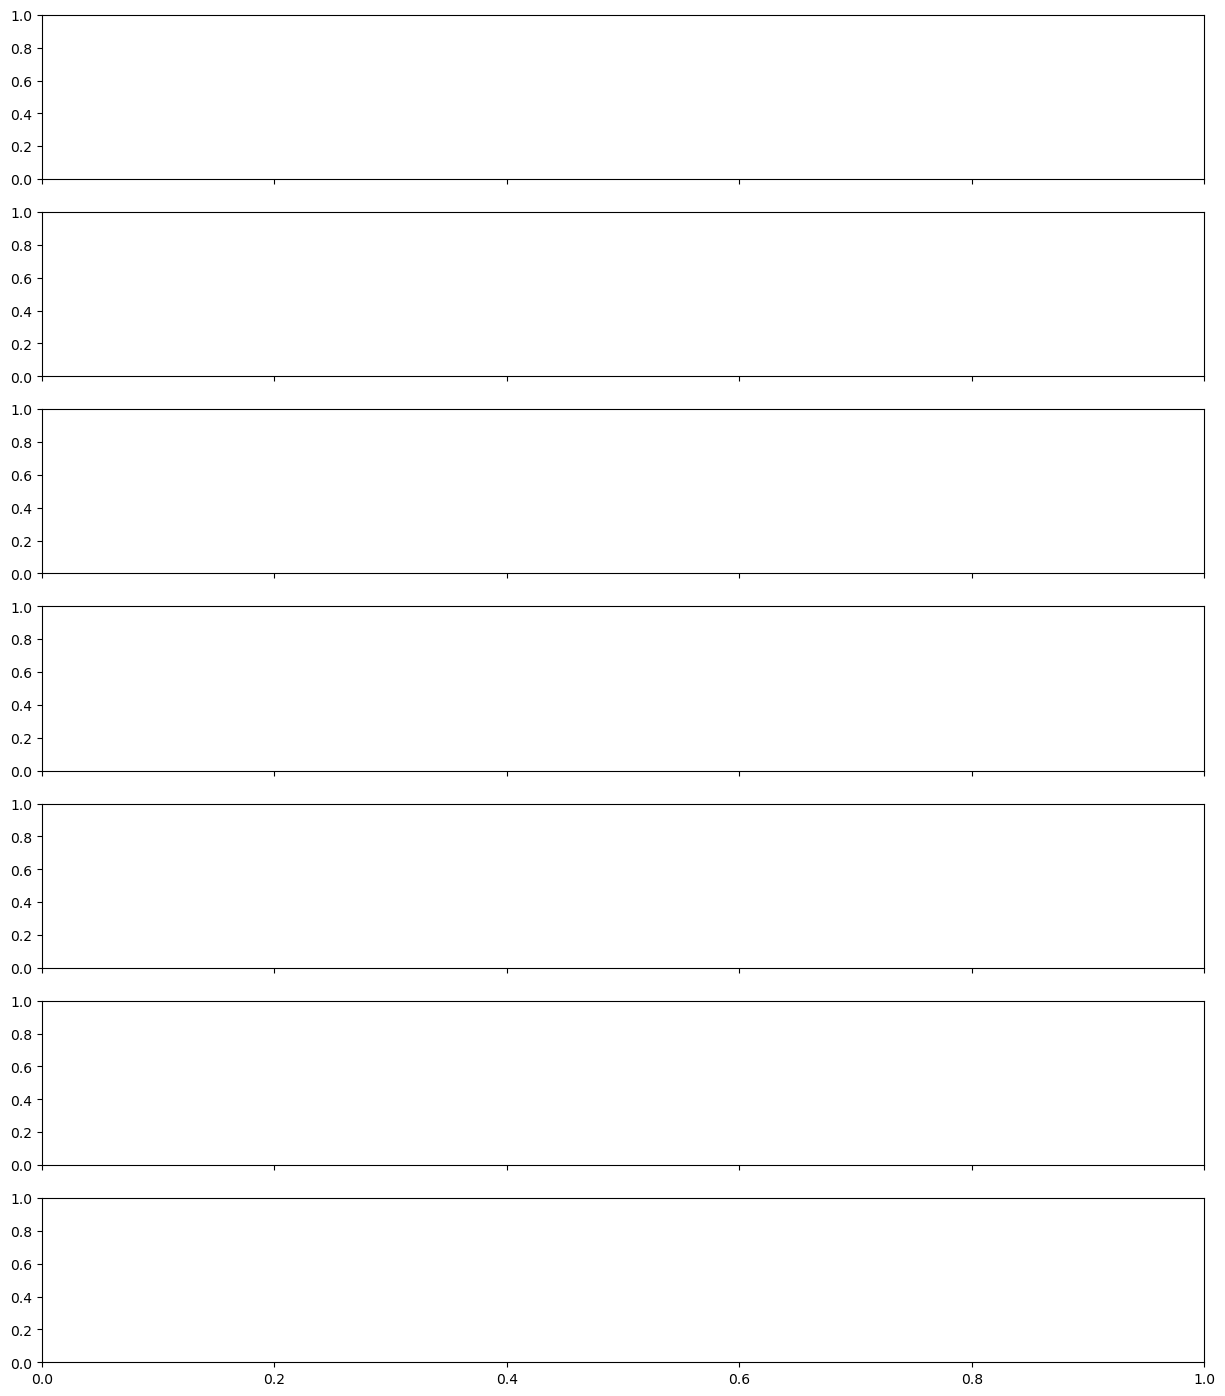

In [118]:
# Unique chromosomes
chromosomes = pre_filtered_df['seq_id'].unique()

# Assign colors to each class/family using a rainbow palette
palette = sns.color_palette('rainbow', len(selected_classes))
class_colors = {cls: palette[i] for i, cls in enumerate(selected_classes)}

# Create a gradient colormap for each class
class_colormaps = {}
for cls, base_color in class_colors.items():
    class_colormaps[cls] = mcolors.LinearSegmentedColormap.from_list(f"{cls}_cmap", ["white", base_color])

# Determine the maximum chromosome length for proportional scaling
max_chrom_length = df['start'].max()

# Create a plot for each chromosome
fig, axes = plt.subplots(len(chromosomes), 1, figsize=(15, 2.5 * len(chromosomes)), sharex=True)  # Adjusted vertical space

if len(chromosomes) == 1:
    axes = [axes]

In [110]:
window_size=100000

In [111]:
def calculate_density(chrom_data, chrom_length, window_size):
    density = np.zeros((chrom_length // window_size) + 1)
    for start, end in zip(chrom_data['start'], chrom_data['start'] + chrom_data['length']):
        start_idx = start // window_size
        end_idx = end // window_size
        for i in range(start_idx, end_idx + 1):
            density[i] += 1
    return density


In [123]:
# Make a copy of the filtered DataFrame to avoid the SettingWithCopyWarning
filtered_df = pre_filtered_df.copy() #this seems unnecesarry. I made a pre file to makea copy of it just to get chrom_data

# Strip quotes from the 'seq_id' column and convert to string
filtered_df['seq_id'] = filtered_df['seq_id'].str.strip("'").astype(str)

# Ensure that 'chromosomes' is a list of strings
chromosomes = [str(chrom) for chrom in chromosomes]

for chrom in chromosomes:
    chrom_data = filtered_df[filtered_df['seq_id'] == chrom]
    chrom_length = chrom_data['start'].max()

chrom_data


,seq_id,start,length,period,score,substitutions,insertions,deletions,consensus,sequence,consolidated_class
487514,cerca.ISC453364.gnm3.Chr07,2133000,208,104,68.238358,14,0,0,AAATCACTGAATCAGGGACGGGACAGTTTCCTGGTAAGTCACTATA...,ATCCCTGTTTCTAACTTGGAAATTTTTCTTGCAGATCACTGAATCA...,Satt_104
487525,cerca.ISC453364.gnm3.Chr07,4053000,208,104,87.889839,7,0,0,AAAAATATCTAAGTCAGAAACAGGGATGAACCGAAACTGGGTCCCG...,GAACCGAAACAGGGTCCCGGTCCAGATATAGTGACTTACCAGGAAA...,Satt_104
487526,cerca.ISC453364.gnm3.Chr07,4761000,208,104,51.394226,20,0,0,AAAAAGGGATGATTCGAAATAGGGTCTTATACCAGATATAGTGACT...,TCCGAGTCAGAAATAGGGATGAACCGAAACAAGGTCCTGAACCAGA...,Satt_104
487527,cerca.ISC453364.gnm3.Chr07,4962455,208,104,62.623291,16,0,0,AAAAATAAGAAAAATATCCGAGTCAGAAACAGGGATGAACCGAAAC...,GTCAGAAAAAGGGAAGAACCGAAACAGGGTCTCGGTCCAGATATAA...,Satt_104
487528,cerca.ISC453364.gnm3.Chr07,5005895,208,104,76.660156,11,0,0,AAAAACAAGAAAAATATCCGAGTCAGAAACAGGGATGAACCGAAAC...,GTCTGAAACAGGGATGAACCGAAACAGGTTCCTGGTCCAGATATAG...,Satt_104
...,...,...,...,...,...,...,...,...,...,...,...
494153,cerca.ISC453364.gnm3.Chr07,3465398,26584,104,8609.039062,0,0,0,AAAAAAAAAAAAAAATTATGAAAGAAAAAAAAGGGAAAAGAGAGAG...,TATACGAGTCAGAAACAGGGATGAACCGAAACAGGGTCCCGGTGCA...,Satt_104
494154,cerca.ISC453364.gnm3.Chr07,3903136,26863,104,9355.588867,0,0,0,AAAAAAAAAAAAAAAAAATAAAAGAAAGAAAAAAAGAAAAAAAGCG...,AGTGATCTACATGAGAAATATCTGAGTCAGAAACAGGGATGAACCG...,Satt_104
494155,cerca.ISC453364.gnm3.Chr07,3969050,31107,104,6201.723633,0,0,0,AAAAAAAAAATTTCGGGTTAAAAAAAGGGGGAAACCCAAAAAGGGG...,AAAATTATACGAGTCAGAAACAGGGATGAACCGAAACAGGGTCCCG...,Satt_104
494156,cerca.ISC453364.gnm3.Chr07,3291064,44927,104,8820.476562,0,0,0,AAAAAAAAAAAAAAAAGAAAAAAAAACCGGGGCCCCCCCAAAAAAT...,ACCGAAGCAGGGACCCGGTCCAGATATAGTGACTCTCCAGGAAAAT...,Satt_104


In [124]:
# Calculate density and max density for each class separately
density_dict = {}
max_density_dict = {cls: 0 for cls in selected_classes}

# Make a copy of the filtered DataFrame to avoid the SettingWithCopyWarning
filtered_df = pre_filtered_df.copy() #this seems unnecesarry. I made a pre file to makea copy of it just to get chrom_data

# Strip quotes from the 'seq_id' column and convert to string
filtered_df['seq_id'] = filtered_df['seq_id'].str.strip("'").astype(str)

# Ensure that 'chromosomes' is a list of strings
chromosomes = [str(chrom) for chrom in chromosomes]

for chrom in chromosomes:
    chrom_data = filtered_df[filtered_df['seq_id'] == chrom]
    chrom_length = chrom_data['start'].max()

chrom_data

,seq_id,start,length,period,score,substitutions,insertions,deletions,consensus,sequence,consolidated_class
487514,cerca.ISC453364.gnm3.Chr07,2133000,208,104,68.238358,14,0,0,AAATCACTGAATCAGGGACGGGACAGTTTCCTGGTAAGTCACTATA...,ATCCCTGTTTCTAACTTGGAAATTTTTCTTGCAGATCACTGAATCA...,Satt_104
487525,cerca.ISC453364.gnm3.Chr07,4053000,208,104,87.889839,7,0,0,AAAAATATCTAAGTCAGAAACAGGGATGAACCGAAACTGGGTCCCG...,GAACCGAAACAGGGTCCCGGTCCAGATATAGTGACTTACCAGGAAA...,Satt_104
487526,cerca.ISC453364.gnm3.Chr07,4761000,208,104,51.394226,20,0,0,AAAAAGGGATGATTCGAAATAGGGTCTTATACCAGATATAGTGACT...,TCCGAGTCAGAAATAGGGATGAACCGAAACAAGGTCCTGAACCAGA...,Satt_104
487527,cerca.ISC453364.gnm3.Chr07,4962455,208,104,62.623291,16,0,0,AAAAATAAGAAAAATATCCGAGTCAGAAACAGGGATGAACCGAAAC...,GTCAGAAAAAGGGAAGAACCGAAACAGGGTCTCGGTCCAGATATAA...,Satt_104
487528,cerca.ISC453364.gnm3.Chr07,5005895,208,104,76.660156,11,0,0,AAAAACAAGAAAAATATCCGAGTCAGAAACAGGGATGAACCGAAAC...,GTCTGAAACAGGGATGAACCGAAACAGGTTCCTGGTCCAGATATAG...,Satt_104
...,...,...,...,...,...,...,...,...,...,...,...
494153,cerca.ISC453364.gnm3.Chr07,3465398,26584,104,8609.039062,0,0,0,AAAAAAAAAAAAAAATTATGAAAGAAAAAAAAGGGAAAAGAGAGAG...,TATACGAGTCAGAAACAGGGATGAACCGAAACAGGGTCCCGGTGCA...,Satt_104
494154,cerca.ISC453364.gnm3.Chr07,3903136,26863,104,9355.588867,0,0,0,AAAAAAAAAAAAAAAAAATAAAAGAAAGAAAAAAAGAAAAAAAGCG...,AGTGATCTACATGAGAAATATCTGAGTCAGAAACAGGGATGAACCG...,Satt_104
494155,cerca.ISC453364.gnm3.Chr07,3969050,31107,104,6201.723633,0,0,0,AAAAAAAAAATTTCGGGTTAAAAAAAGGGGGAAACCCAAAAAGGGG...,AAAATTATACGAGTCAGAAACAGGGATGAACCGAAACAGGGTCCCG...,Satt_104
494156,cerca.ISC453364.gnm3.Chr07,3291064,44927,104,8820.476562,0,0,0,AAAAAAAAAAAAAAAAGAAAAAAAAACCGGGGCCCCCCCAAAAAAT...,ACCGAAGCAGGGACCCGGTCCAGATATAGTGACTCTCCAGGAAAAT...,Satt_104


In [126]:
for chrom_idx, (ax, chrom) in enumerate(zip(axes, chromosomes)):
    chrom_data = df[df['sequence'] == chrom]
    chrom_length = chrom_data['start'].max() + chrom_data['length'].max()  # Ensure chrom_length accounts for the end position

    # Draw the chromosome ideogram as a horizontal bar
    ax.add_patch(mpatches.Rectangle((0, 1.1), chrom_length, 0.1, color='lightgrey', zorder=0))

    if window_size: #change to args.window_size
        window_size = window_size  #change to args.window_size
        for class_idx, cls in enumerate(selected_classes):
            density = density_dict[chrom][cls]
            cmap = class_colormaps[cls]
            max_density = max_density_dict[cls]
            norm = mcolors.Normalize(vmin=0, vmax=max_density)
            y_position = 1.0 - class_idx * 0.12  # Adjusted spacing between tracks
            for i, count in enumerate(density):
                if count > 0:
                    color = cmap(norm(count))
                    ax.add_patch(mpatches.Rectangle((i * window_size, y_position), window_size, 0.1, color=color, zorder=1))
            if chrom_idx == 0:
                ax.text(-0.05 * chrom_length, y_position + 0.02, cls, va='center', ha='right', fontsize=10)  # Add class name for the first chromosome
    else:
        # Draw repeat sequences
        for class_idx, cls in enumerate(selected_classes):
            class_data = chrom_data[chrom_data['consolidated_class'] == cls]
            y_position = 1.0 - class_idx * 0.12  # Adjusted spacing between tracks
            for _, row in class_data.iterrows():
                start = row['start']
                length = row['length']
                end = start + length
                ax.add_patch(mpatches.Rectangle((start, y_position), end - start, 0.1, color=class_colors[row['consolidated_class']], zorder=1))
            if chrom_idx == 0:
                ax.text(-0.05 * chrom_length, y_position + 0.02, cls, va='center', ha='right', fontsize=10)  # Add class name for the first chromosome

    ax.set_xlim(0, chrom_length)
    ax.set_ylim(0.85 - 0.12 * len(selected_classes), 1.2)  # Adjusted ylim to fit tracks properly
    ax.set_yticks([])
    ax.set_title(f'Chromosome: {chrom} (Size: {chrom_length} bp)', fontsize=10)


KeyError: 'cerca.ISC453364.gnm3.Chr01'

In [128]:
density_dict[chrom]

KeyError: 'cerca.ISC453364.gnm3.Chr01'